# Covid-19 Polynomial Fitting

The aim of this notebook is to identify the optimal model from a given simple
parametric family that best characterizes the growth curve of COVID-19 cases without 
overfitting the data.  
The first part of the dataset (up to 20 March) will be used for training, along [Bayesian Information Criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion) for selecting the degree of our polynomial.  
The chosen model will be tested on the rest of the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import datetime

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

## Data gathering

As in the [previous notebook](https://github.com/MikeXydas/Weekend-EDAs/blob/master/Covid19_Testing_Importance.ipynb) the number of confirmed cases will be taken from the [John Hopkins](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv) dataset which is daily updated.  
We will group by country name and sum over provinces/states so as to have the cases per country.

In [2]:
confirmed_cases_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', 
                                 index_col=['Country/Region'])

# Drop unused columns Lat, Long
confirmed_cases_df = confirmed_cases_df.drop('Lat', axis=1)
confirmed_cases_df = confirmed_cases_df.drop('Long', axis=1)

# Group by and sum number of cases of each country
confirmed_cases_df = confirmed_cases_df.groupby(['Country/Region']).sum()

display(confirmed_cases_df)

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,22,22,22,24,24,40,40,74,84,94
Albania,0,0,0,0,0,0,0,0,0,0,...,55,59,64,70,76,89,104,123,146,174
Algeria,0,0,0,0,0,0,0,0,0,0,...,60,74,87,90,139,201,230,264,302,367
Andorra,0,0,0,0,0,0,0,0,0,0,...,39,39,53,75,88,113,133,164,188,224
Angola,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,2,2,3,3,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela,0,0,0,0,0,0,0,0,0,0,...,33,36,42,42,70,70,77,84,91,107
Vietnam,0,2,2,2,2,2,2,2,2,2,...,66,75,85,91,94,113,123,134,141,153
West Bank and Gaza,0,0,0,0,0,0,0,0,0,0,...,39,41,44,47,48,52,59,59,59,84


We will try to forecast the global number of cases so we can sum the rows. However, we keep the `confirmed_cases_df` DataFrame in case we need it for comparisons.

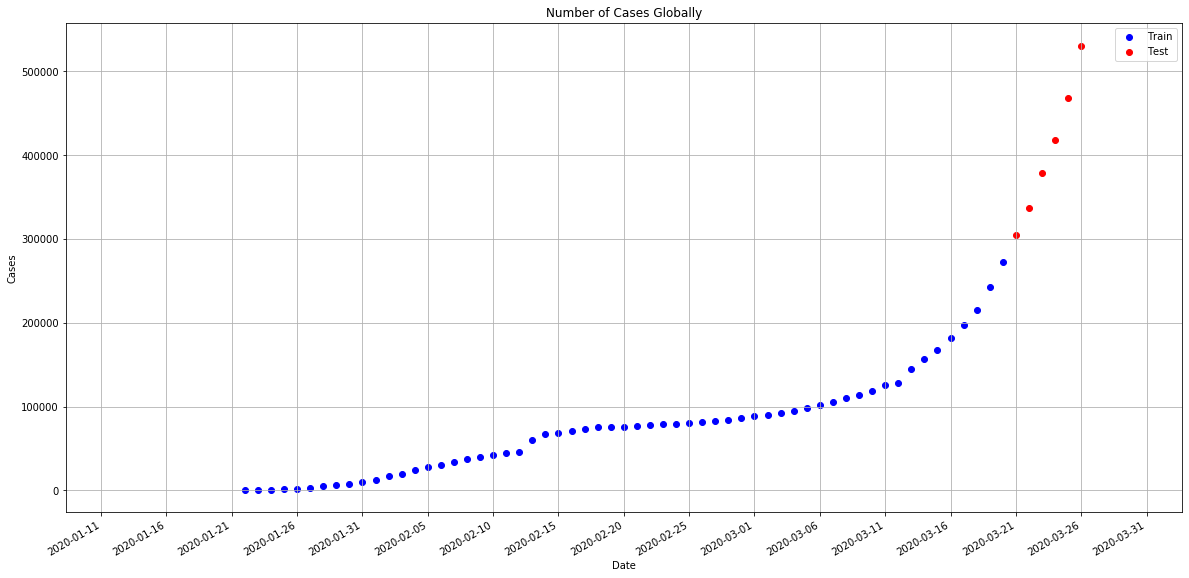

In [6]:
global_cases_df = confirmed_cases_df.sum()    # Sum over all countries to get global number of cases for each day

# Plot the number of cases for each day globally
x_values = [datetime.datetime.strptime(d[:-2]+ '20' + d[-2:],"%m/%d/%Y").date() for d in global_cases_df.index]
y_values = global_cases_df.values

fig, ax = plt.subplots(figsize=(20, 10))
ax = plt.gca()
formatter = mdates.DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(formatter)

locator = mdates.DayLocator(interval=5)    # Add an interval on the x-axis so as to not be cluttered
ax.xaxis.set_major_locator(locator)

# We will use the last 6 days as a test set
plt.scatter(x_values[:-6], y_values[:-6], color="blue", label="Train")
plt.scatter(x_values[-6:], y_values[-6:], color="red", label="Test")

ax.set_xlabel("Date")
ax.set_ylabel("Cases")
plt.title("Number of Cases Globally")
plt.legend()

plt.grid()
plt.gcf().autofmt_xdate()
plt.show()

## Global Cases - Polynomial Regression

Firstly, we will create a model able to forecast future global number of future cases. This will help us have a greater understanding of a pipeline we could create to do the same calculations for each country separately.  
On the above plot we will use the blue part in order to find the degree of our polynomial and train our linear regression model and the red part for testing.
### Training

In [25]:
x_series = np.arange(len(x_values))    # Transform dates to an integer mapping for easier parsing

# Split the data in training and testing and
# add a new axis so as the PolynomialFeatures input has the expected 2D shape
train_X = x_series[:-6, np.newaxis]
train_Y = y_values[:-6, np.newaxis]

test_X = x_series[-6:, np.newaxis]
test_Y = y_values[-6:, np.newaxis]

# Calculate the models up to 9th degree and cache them in a dictionary
models_dict = {}
for degree in range(1,10):
    # Create the new features
    # eg degree=2, [a] => [a^0, a^1, a^2]
    polynomial_features = PolynomialFeatures(degree=degree)
    x_poly = polynomial_features.fit_transform(train_X)

    # Train a linear regression model with our new polynmial feature set
    model = LinearRegression()
    model.fit(x_poly, train_Y)
    
    # Cache the model and the new set of features
    models_dict[degree] = [model, x_poly]

(6, 1)


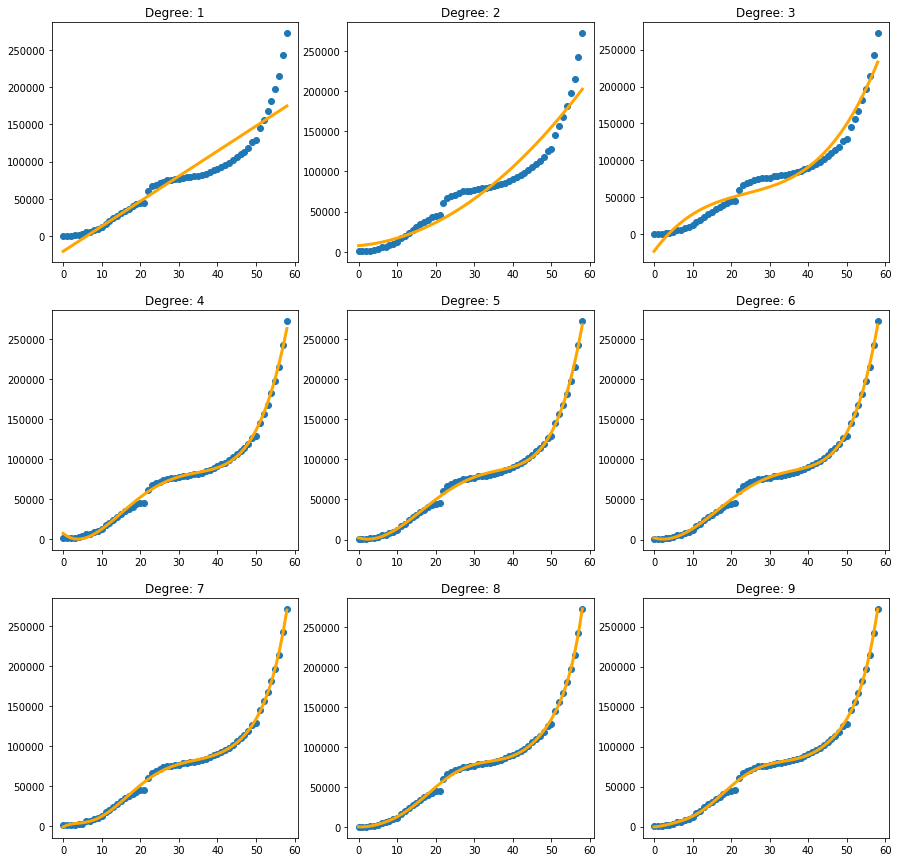

In [8]:
fig = plt.figure(figsize=(15, 15))
plot_index = 1

# We will create 9 plots one for each degree
for degree, model_features in models_dict.items():
    ax = fig.add_subplot(3, 3, plot_index)
    
    # Plot our true data
    plt.scatter(train_X, train_Y)
    
    # Use our new model to predict on our train set
    pred_train_Y = model_features[0].predict(model_features[1])    
    
    plt.plot(train_X, pred_train_Y, linewidth=3, label=f'Degree: {str(degree)}', color="orange")
    plot_index += 1
    
    plt.title(f"Degree: {degree}")
    
    
plt.show()

**Visually** we observe that the polynomial of the **4th degree** is the simplest model that seems to be good at capturing the shape of our data. To prove this with a more robust way we will use the **Bayesian Information Criterion (BCI)**.
  
### Metrics
**BCI**: Bayesian information criterion (BIC) is a criterion for model selection among a finite set of models. It deals with overfitting since it **penalizes models that need many parameters**. So in our case as the degree of the polynomial increases the penalty will increase too.

$$BIC = kln(n) -2ln(\hat{L})$$
* $n$ is the number of data points (number of days used for training)
* $k$ is the number of free parameters (in our case degree + 1 due to intercept)
* $\hat{L}$ is the maximized value of the likelihood of our model

In order to calculate the $\hat{L}$ we first make some assumptions.  
Linear regression is in the form of $Y = Xβ + ε$ where $ε$ is the residue between the prediction and the true data result.  
Assuming that our residue $ε$ is **independent Gaussian noise** we can prove that the **maximum likelihood equals the mean squared error metric** [(ref)](https://www.stat.cmu.edu/~cshalizi/mreg/15/lectures/06/lecture-06.pdf).
  
Under these assumptions we calculate BIC [(ref)](https://en.wikipedia.org/wiki/Bayesian_information_criterion#Gaussian_special_case):
$$BIC = nln(mse) + kln(n)$$

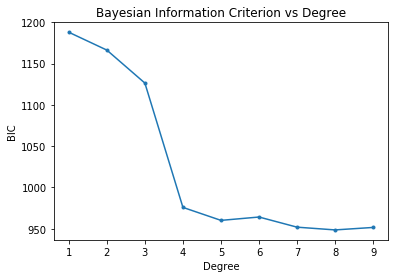

In [9]:
# Calculate MSE of Linear regression model
mse = mean_squared_error(train_Y, pred_train_Y)

# Calculate BIC for each model degree
bics = []
for degree, model_features in models_dict.items():
    # Use our new model to predict on our train set
    pred_train_Y = model_features[0].predict(model_features[1])

    mse = mean_squared_error(train_Y, pred_train_Y)
    n = len(train_Y)
    k = degree + 1    # We +1 for the intercept
    
    bics.append(n * np.log(mse) + k * np.log(n))


plt.plot(np.arange(1, len(bics) + 1), bics, marker=".")

plt.xlabel("Degree")
plt.ylabel("BIC")
plt.title("Bayesian Information Criterion vs Degree")

plt.show()

On the above plot we can see that the major on BIC happens from the 3rd to the 4th degree. However we need a rule in order to decide from the other models of degree 4 to 9.  
A usual criterion is [(ref)](https://en.wikipedia.org/wiki/Bayesian_information_criterion#Gaussian_special_case):  
  
Let $B^{\ast}$ be the lowest BIC value and $B$ a different BIC than $B^{\ast}$
* if $B - B^{\ast} < 2$, the difference is not important
* if $2 \leq B - B^{\ast} < 6$, the difference is positive
* if $6 \leq B - B^{\ast} \leq 10$, the difference is strong
* if $B - B^{\ast} > 10$, the difference is very strong

So we will deem as the best model **the one that has smallest degree and its BIC is not bigger than 2 from the model with the lowest BIC**.

In [16]:
def find_simplest_min_bic(bics, criterion=2):
    """Finds the smallest bic following the above rule"""
    true_min = np.argmin(bics)
    for which_bic in range(true_min):
        if bics[which_bic] - bics[true_min] < criterion:
            return which_bic    # Return the bic index that was the simplest model and B - B* < criterion(2)
    return true_min    # No B != B* with B - B* < criterion(2) found, return the index of the smallest bic 

bic_degree = find_simplest_min_bic(bics) + 1
print(f"Best BIC Degree: {bic_degree}")

Best BIC Degree: 8


We can see that the model that covers our criterion is the one of the **8th degree**. Following [Occam's razor](https://en.wikipedia.org/wiki/Occam%27s_razor) we could relax our above criterion to a higher value and pick a more parsimonious model.

### Testing

Having found the degree of the polynomial that best fits our data without overfitting we must now forecast some dates that were not used in training (the last 6 days in our case) and evaluate our model's performance.

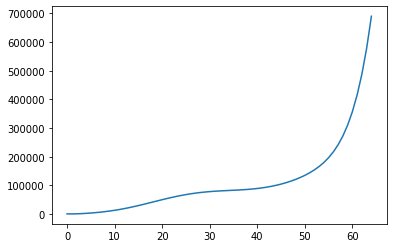

In [31]:
# Transform our train and test data to much the expected input degree of our chosen model
polyn_test_features = PolynomialFeatures(degree=bic_degree)
x_poly_train_test = polyn_test_features.fit_transform(np.vstack((train_X, test_X)))

#Get the model
chosen_model = models_dict[bic_degree]
pred_train_test_Y = chosen_model[0].predict(x_poly_train_test)

plt.plot(np.vstack((train_X, test_X)), pred_train_test_Y)
plt.show()